<a href="https://colab.research.google.com/github/marc1971/Assignement-Module4-CAS-NLP/blob/main/final_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

### Connecting to HuggingFace

In [8]:
from huggingface_hub import notebook_login

notebook_login()

### Connecting to GoogleDrive

In [9]:
# Connecting to Google Drive to get access to data, that is used for training the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Necessary imports

In [3]:
!pip install -q -U torch==2.1.0 datasets transformers tensorflow langchain playwright html2text sentence_transformers faiss-cpu
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7 typing-extensions==4.6.1 pyarrow==14.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.8/811.8 kB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

### Dependencies

In [4]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline
)
from datasets import load_dataset
from peft import LoraConfig, PeftModel

from langchain.text_splitter import CharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

### Load quantized Mistal 8x7B

In [5]:
#################################################################
# Tokenizer
#################################################################

model_name='mistralai/Mixtral-8x7B-Instruct-v0.1'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16

if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Your GPU supports bfloat16: accelerate training with bf16=True


config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/92.7k [00:00<?, ?B/s]

model-00001-of-00019.safetensors:   0%|          | 0.00/4.89G [00:00<?, ?B/s]

model-00002-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00005-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00006-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00007-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00008-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00009-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00010-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00011-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00012-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00013-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00014-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00015-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00016-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00017-of-00019.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00018-of-00019.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00019-of-00019.safetensors:   0%|          | 0.00/4.22G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Count number of trainable parameters

In [6]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 262410240
all model parameters: 23482601472
percentage of trainable model parameters: 1.12%


### Build Mistral text generation pipeline

In [7]:
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    do_sample = True,
    max_new_tokens=1000,
)

In [8]:
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

### Load and chunk documents. Load chunked documents into FAISS index

In [ ]:
!playwright install
!playwright install-deps

## Loading Text Documents

The source of the text is different documents stored on Googledrive. There are actually 37 Documents with different number of characters.

In [10]:
from text_loader import load_text


In [11]:
dict_path = '/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/Textdata/'
texts = load_text(dict_path, 'all')

In [12]:
len(texts)

37

In [13]:
print('Number of Documents: ',len(texts))
print('Nummer of Characters of the different Documents:', [len(texts[i]) for i in range(len(texts))])

Number of Documents:  37
Nummer of Characters of the different Documents: [1291, 15135, 7178, 12476, 30276, 24598, 24632, 4698, 2461, 2959, 23690, 18321, 16531, 10850, 4443, 2594, 18649, 11961, 12707, 29260, 6103, 32785, 4467, 2033, 2133, 32903, 21596, 3254, 24021, 24021, 21734, 6340, 4346, 17057, 32809, 13281, 9545]


In [14]:
#Example of Document
texts[0]

'Reglement über die Aufgaben und Befugnisse der Vizerektorin oder des Vizerektors vom 20. Juni 2023.\nDer Rektor der Pädagogischen Hochschule, gestützt auf Artikel 10 Absatz 2 und Artikel 39 Absatz 1 Buchstabe n des Gesetzes vom 8. September 2004 über die deutschsprachige Pädagogische Hochschule (PHG)1 sowie in Ausführung von Artikel 3 Absatz 6 des Statuts der deutschsprachigen Pädagogischen Hochschule vom 12. Juni 2018 (PHSt)2, beschliesst: Dieses Reglement regelt die Zuweisung von Aufgaben der Rektorin oder des Rektors der Pädagogischen Hochschule an die Vizerektorin oder den Vizerektor sowie deren oder dessen Vertretungsbefugnis. Die Vizerektorin oder der Vizerektor hat während längerer Abwesenheiten der Rektorin oder des Rektors sämtliche Kompetenzen der- oder desselben inne, leitet das Programm «Strategisches Hochschulprozessmanagement», ist zuständig für die Bereichsleitungskonferenzen, kann die Rektorin oder den Rektor an Anlässen vertreten. Entscheidungen von grösserer Tragweit

## Text Analysis

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
text_all = " ".join([str(text) for text in texts])
len(text_all)

533174

Häufigstes Vorkommen:  3213 mal
2729 Wörter kommen nur 1-mal vor im Text.


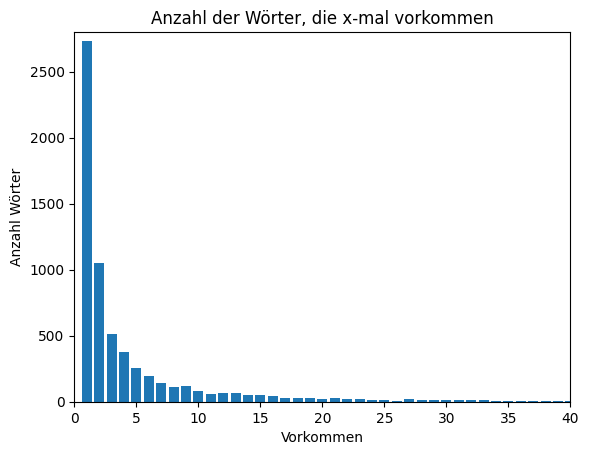

In [17]:
from collections import Counter
import re


# Normalize the text to lowercase and remove non-alphanumeric characters
words = re.findall(r'\b\w+\b', text_all.lower())

# Count the words
word_counts = Counter(words)
counts = list(word_counts.values())
counts.sort()
c_counts = Counter(counts)

vorkommen = list(c_counts.keys())
anzahl = list(c_counts.items())
y = [tup[1] for tup in anzahl]

print('Häufigstes Vorkommen: ', max(vorkommen), 'mal')
print(max(y), 'Wörter kommen nur 1-mal vor im Text.')


plt.bar(vorkommen, y)
plt.title('Anzahl der Wörter, die x-mal vorkommen')
plt.xlim(0,40)
plt.ylim(0,2800)
plt.xlabel('Vorkommen')
plt.ylabel('Anzahl Wörter')
plt.show()

In [18]:
#Unique Words count

unique_words = set(words)  # 'words' from the previous example
print(f"Number of unique words: {len(unique_words)}")

Number of unique words: 6490


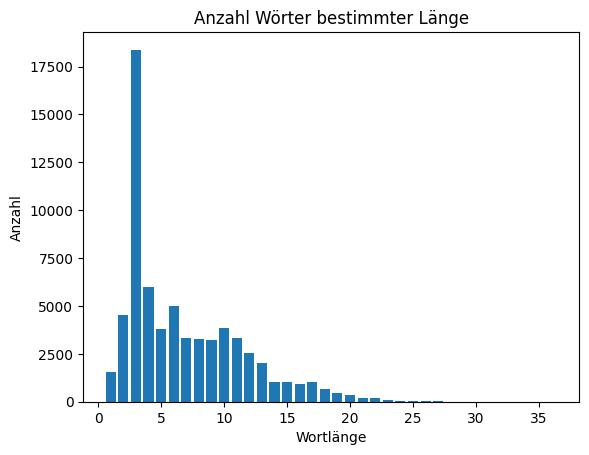

In [19]:
word_lengths = [len(word) for word in words]
length_counts = Counter(word_lengths)

# Display the count of each word length
w_length = []
w_count = []
for length, count in sorted(length_counts.items()):
    w_length.append(length)
    w_count.append(count)
    #print(f"Length {length}: {count} times")

plt.bar(w_length, w_count)
plt.title('Anzahl Wörter bestimmter Länge')
plt.xlabel('Wortlänge')
plt.ylabel('Anzahl')
plt.show()

In [ ]:
!pip install textstat
import textstat

readability_score = textstat.flesch_reading_ease(text_all)
print(f"Flesch Reading Ease: {readability_score}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.8 MB/s eta 0:00:00
Flesch Reading Ease: 38.11


In [20]:
from nltk.util import ngrams

bigrams = ngrams(words, 2)
bigram_counts = Counter(bigrams)

# Display the 5 most common bigrams
print(bigram_counts.most_common(5))

[(('für', 'die'), 260), (('die', 'studierenden'), 254), (('in', 'der'), 223), (('über', 'die'), 222), (('pädagogischen', 'hochschule'), 212)]


## Split the Text in Chunks

### 1. Set up the CharacterTextSplitter to split then the Text in Chunks.

In [21]:
from text_loader import text_splitting

In [22]:
from langchain.text_splitter import CharacterTextSplitter
chunk_size = 500
overlap = 0

text_splitter = text_splitting(chunk_size, overlap, separator="")

### 2. Writing out the first line of each document, since it is the title of the document.

In [23]:
from text_loader import get_text_before_newline

### 3. Creating a LangChain-Document

The Document *'documents'* is a list of LangChain-Objects, created with the help of the *'create_documents'*-methode of the TextSplitter that containes dicionaries with the keys *'page_content'* and *'metadata'*.

In [24]:
from text_loader import create_LangChain_doc

In [25]:
documents = create_LangChain_doc(texts, chunk_size, overlap, separator="")

In [26]:
len(documents)

1086

In [27]:
documents[10]

Document(page_content='und organisatorische Massnahmen gemäss den Artikeln 4 bis 6 der Datenschutzverordnung vom 22. Oktober 2008 zu schützen. Der Rechtsdienst erarbeitet hierzu eine Checkliste. Personendaten werden grundsätzlich nur bei den betroffenen Personen bzw. deren gesetzlichen Vertreterinnen und Vertretern beschafft. Bei systematischen Erhebungen muss die Rechtsgrundlage und der Zweck der Beschaffung angegeben sowie, falls keine Auskunftspflicht besteht, auf die Freiwilligkeit der Auskunft hingewiesen werden.', metadata={'document': 'Weisungen über den Umgang mit Personendaten (Datenschutzweisungen) vom 29. Juni 2021.'})

In [28]:
print(type(documents[1]))
print(len(documents[1].page_content))
print(documents[7].page_content)
print(documents[1].metadata)

<class 'langchain_core.documents.base.Document'>
499
schutzrecht verstösst; Mitarbeiterinnen und Mitarbeiter: Mitarbeiterinnen und Mitarbeiter der Pädagogischen Hochschule gemäss Artikel 11 Absatz 2 PHG. Die Mitarbeiterinnen und Mitarbeiter bearbeiten Personendaten nur, wenn und soweit sie durch Gesetz oder Verordnung dazu ermächtigt werden oder b dies für die Erfüllung ihrer dienstrechtlichen Verpflichtungen gegenüber der Pädagogischen Hochschule erforderlich ist. Die Mitarbeiterinnen und Mitarbeiter bearbeiten besonders schützenswerte Personenda
{'document': 'Reglement über die Aufgaben und Befugnisse der Vizerektorin oder des Vizerektors vom 20. Juni 2023.'}


As expected the length of the content in each entry is 500 (499) characters. (no idea why 499???)

### 4. Splitting the LangChain-Document in Chunks

Now we have to make a List of all Document-Entries. It can be done with the *'split_documents'*-methode.

In [29]:
from text_loader import chunk_docs

In [30]:
chunked_documents = chunk_docs(documents,chunk_size, overlap, separator="")

In [31]:
print(len(chunked_documents))

1086


## Creating a Vector-Database and building a Retriever

In [38]:
# Load chunked documents into the FAISS index
db = FAISS.from_documents(chunked_documents,
                          HuggingFaceEmbeddings(model_name='PM-AI/bi-encoder_msmarco_bert-base_german'))

# Connect query to FAISS index using a retriever

retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 4}
)

### Create PromptTemplate and LLMChain

In [39]:
prompt_template = """
### [INST]

Instruction: Beantworte die Frage aufgrund deines Wissens über die PHBern. Antworte in **ZWEI bis DREI DEUTSCHEN Sätzen**! Hier ist der context als Hilfe:

{context}

### QUESTION:
{question}

[/INST]
 """

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create llm chain by pasting together the Text_generation-Pipeline 'mistral_lmm' and the prompt
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)


#Answer the question based on your knowledge about PHBern. Answer in german! Here is context to help:

In [40]:
llm_chain.invoke({"context": "", "question": "Wie lange werden meine Arbeitszeugnisse an der PHBern aufbewahrt?"})

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'context': '',
 'question': 'Wie lange werden meine Arbeitszeugnisse an der PHBern aufbewahrt?',
 'text': '\nDie Personalabteilung der Pädagogischen Hochschule Bern (PHBern) bewahrt Arbeitszeugnisse grundsätzlich für einen Zeitraum von 10 Jahren nach Beendigung des Arbeitsverhältnisses auf. Dies entspricht den gesetzlichen Aufbewahrungsfristen in der Schweiz. In einigen Fällen, wie beispielsweise bei langjährigen Mitarbeitenden oder solchen mit herausragenden Leistungen, kann die PHBern die Dokumente auch darüber hinaus aufbewahren.'}

### Build RAG Chain

The RAG Chain finally is the all glued together: the Generator-Pipeline *'mistral_lmm'*, the *PromptTemplate* (prompt), augmented by an external context, found by the *retriever*!

In [41]:
rag_chain = ( {"context": retriever, "question": RunnablePassthrough()} | llm_chain )

result = rag_chain.invoke("Wie lange werden meine Arbeitszeugnisse an der PHBern aufbewahrt?")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [42]:
result['context']

[Document(page_content='erenden des Abschlusskolloquiums, spätestens jedoch zwei Wochen vor dem Abschlusskolloquium. Die Zeitfenster sind im Anlassverzeichnis aufgeführt. Die Studierenden arbeiten während der gesamten Ausbildung am IS2 der PHBern am Berufskonzept. Sie schreiben sich in die Lerngelegenheiten des Moduls Transfer und Vernetzung parallel zur Einschreibung in die Module Einführungspraktikum und/oder Fachpraktikum wie folgt ein: Lerngelegenheit, Voraussetzung, Einschreibung, Orientierungstag. Es erfolgt auto', metadata={'document': 'Wegleitung TRANSFER UND VERNETZUNG.'}),
 Document(page_content='Informationen des Rechtsdiensts zur Entschädigung bei Praktika.\nDie Studierenden der PHBern absolvieren in allen Grundausbildungsstudiengängen eine Berufspraktische Ausbildung. Diese besteht aus „praktisch angelegten, professionell begleiteten Lehr- und Lernanlässen, welche im unmittelbaren Kontakt mit dem Berufsfeld der Förderung der Handlungskompetenz als Lehrperson dienen“, und d

In [43]:
print(result['text'])

 Nach erfolgtem Stellenaustritt werden Arbeitszeugnisse und Bestätigungen sowie für deren Ausstellung notwendige Unterlagen an der PHBern zehn Jahre lang aufbewahrt.


## Benchmarking

Here we check the similarity between the resulting answers of our RAG and the ground truth answers. Therefore we load en Exel File wich 1030 Q+As.

In [17]:
import pandas as pd

df = pd.read_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA.xlsx")


Apply the RAG-Chain to all the Questions in the Q+A Document and make a new column with predictions.

In [ ]:
from tqdm import tqdm

In [18]:
len(df)

1033

In [ ]:
n_preds = len(df)

df['pred'] = df['question'][:n_preds].apply(lambda x: rag_chain.invoke(x)['text'])

In [47]:
df.head()

,id,title,question,answer,context,document,Unnamed: 6,Unnamed: 7,Unnamed: 8,pred
0,1,Reglement über die Aufgaben und Befugnisse der...,"Was geschieht, wenn der Rektor oder die Rektor...",Die Vizerektorin oder der Vizerektor hat währe...,"Der Rektor der Pädagogischen Hochschule, gestü...","Der Rektor der Pädagogischen Hochschule, gestü...",NaN,NaN,NaN,\nLaut dem Reglement über die Aufgaben und Bef...
1,2,Reglement über die Aufgaben und Befugnisse der...,Welche Befugnisse hat die Vizerektorin oder de...,Sie oder er leitet das Programm «Strategisches...,"Der Rektor der Pädagogischen Hochschule, gestü...","Der Rektor der Pädagogischen Hochschule, gestü...",NaN,NaN,NaN,Laut dem Reglement über die Aufgaben und Befu...
2,3,Reglement über die Aufgaben und Befugnisse der...,Kann die Vizerektorin oder der Vizerektor in A...,Entscheidungen von grösserer Tragweite fällt d...,"Der Rektor der Pädagogischen Hochschule, gestü...","Der Rektor der Pädagogischen Hochschule, gestü...",NaN,NaN,NaN,"Ja, laut dem Reglement über die Aufgaben und ..."
3,4,Weisungen über den Umgang mit Personendaten (D...,Was sind Personendaten?,Personendaten sind sämtliche Angaben über eine...,Diese Weisungen regeln den Umgang mit Personen...,Diese Weisungen regeln den Umgang mit Personen...,NaN,NaN,NaN,Personendaten sind alle Angaben über eine bes...
4,5,Weisungen über den Umgang mit Personendaten (D...,Was sind besonders schützenswerte Personendaten?,Besonders schützenswerte Personendaten sind Da...,Diese Weisungen regeln den Umgang mit Personen...,Diese Weisungen regeln den Umgang mit Personen...,NaN,NaN,NaN,\nBesonders schützenswerte Personendaten sind ...


In [48]:
df.to_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA_pred.xlsx", index=False)

In [16]:
df[['question', 'answer', 'pred']].tail()

NameError: name 'df' is not defined

### Calculating Cosine-Similatities

In [19]:
import pandas as pd

df_pred = pd.read_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA_pred.xlsx")

In [20]:
df_pred.tail()

,id,title,question,answer,context,document,Unnamed: 6,Unnamed: 7,Unnamed: 8,pred
1028,1029,Wegleitung BERUFSPRAKTISCHE AUSBILDUNG,"Woher bekomme ich das Formular, um ein Praktik...",Das Formular Abbruch Praktikum kann bei der Be...,Die Beteiligten gehen wie folgt vor: Schriftli...,Alle Studierenden des Instituts Sekundarstufe ...,NaN,NaN,NaN,Gemäss den Studienreglementen der PH Bern kan...
1029,1030,Wegleitung BERUFSPRAKTISCHE AUSBILDUNG,"Was geschieht, wenn ich einen wichtigen Grund ...",Liegt ein wichtiger Grund für den Abbruch des ...,Die Beteiligten gehen wie folgt vor: Schriftli...,Alle Studierenden des Instituts Sekundarstufe ...,NaN,NaN,NaN,\nLaut dem Studienreglement für das Bachelor- ...
1030,1031,Wegleitung BERUFSPRAKTISCHE AUSBILDUNG,Kann ich mit einer ungenügenden Prüfungslektio...,Ein ungenügender Leistungsnachweis Prüfungslek...,Berufspraktische Arbeit wiederholt werden (vgl...,Alle Studierenden des Instituts Sekundarstufe ...,NaN,NaN,NaN,Laut den Allgemeinen Zulassungsweisungen vom ...
1031,1032,Wegleitung BERUFSPRAKTISCHE AUSBILDUNG,Gibt es am IS2 der Phbern ein Verfahren zur Pr...,Am IS2 der PHBern findet die Prüfung der Eignu...,Berufspraktische Arbeit wiederholt werden (vgl...,Alle Studierenden des Instituts Sekundarstufe ...,NaN,NaN,NaN,\nAufgrund der bereitgestellten Informationen ...
1032,1033,Wegleitung BERUFSPRAKTISCHE AUSBILDUNG,Ist das Einfühungspraktikum ein Einzelpraktikum?,Im Einführungspraktikum werden einer Praxisleh...,Berufspraktische Arbeit wiederholt werden (vgl...,Alle Studierenden des Instituts Sekundarstufe ...,NaN,NaN,NaN,"\nNein, das Einführungspraktikum ist nicht zwi..."


In [11]:
from transformers import AutoModel, AutoTokenizer
import torch
from scipy.spatial.distance import cosine
import numpy as np

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('PM-AI/bi-encoder_msmarco_bert-base_german')
model = AutoModel.from_pretrained('PM-AI/bi-encoder_msmarco_bert-base_german')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/729k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [27]:
s1 = df_pred['answer'].to_list()
s2 = df_pred['pred'].to_list()

n_preds = len(s1)

In [25]:
# Define your sentences
cos_sim = []

for i in range(len(s1)):
  sentence1 = s1[i]
  sentence2 = s2[i]
# Tokenize the sentences
  tokens1 = tokenizer(sentence1, return_tensors='pt', padding=True, truncation=True)
  tokens2 = tokenizer(sentence2, return_tensors='pt', padding=True, truncation=True)

# Generate embeddings
  with torch.no_grad():
    embeddings1 = model(**tokens1).last_hidden_state.mean(dim=1)
    embeddings2 = model(**tokens2).last_hidden_state.mean(dim=1)

# Calculate cosine similarity
  cosine_similarity = 1 - cosine(embeddings1[0].numpy(), embeddings2[0].numpy())
  cos_sim.append(cosine_similarity)

In [26]:
print(len(cos_sim))

1033


In [28]:
df_pred['similarity'] = np.nan  # Initialize the column with NaN
df_pred.loc[:n_preds-1, 'similarity'] = cos_sim

In [29]:
df_pred[['question', 'answer', 'pred', 'similarity']][:n_preds]

,question,answer,pred,similarity
0,"Was geschieht, wenn der Rektor oder die Rektor...",Die Vizerektorin oder der Vizerektor hat währe...,\nLaut dem Reglement über die Aufgaben und Bef...,0.988163
1,Welche Befugnisse hat die Vizerektorin oder de...,Sie oder er leitet das Programm «Strategisches...,Laut dem Reglement über die Aufgaben und Befu...,0.977954
2,Kann die Vizerektorin oder der Vizerektor in A...,Entscheidungen von grösserer Tragweite fällt d...,"Ja, laut dem Reglement über die Aufgaben und ...",0.985102
3,Was sind Personendaten?,Personendaten sind sämtliche Angaben über eine...,Personendaten sind alle Angaben über eine bes...,0.981643
4,Was sind besonders schützenswerte Personendaten?,Besonders schützenswerte Personendaten sind Da...,\nBesonders schützenswerte Personendaten sind ...,0.998193
...,...,...,...,...
1028,"Woher bekomme ich das Formular, um ein Praktik...",Das Formular Abbruch Praktikum kann bei der Be...,Gemäss den Studienreglementen der PH Bern kan...,0.948755
1029,"Was geschieht, wenn ich einen wichtigen Grund ...",Liegt ein wichtiger Grund für den Abbruch des ...,\nLaut dem Studienreglement für das Bachelor- ...,0.979298
1030,Kann ich mit einer ungenügenden Prüfungslektio...,Ein ungenügender Leistungsnachweis Prüfungslek...,Laut den Allgemeinen Zulassungsweisungen vom ...,0.972388
1031,Gibt es am IS2 der Phbern ein Verfahren zur Pr...,Am IS2 der PHBern findet die Prüfung der Eignu...,\nAufgrund der bereitgestellten Informationen ...,0.975014


In [33]:
mean_sim = np.mean(cos_sim)
print(mean_sim)
print(max(cos_sim))
print(min(cos_sim))

0.9755734430855034
0.9997918009757996
0.9313672780990601


### Calculating BertScore

In [34]:
import os

os.environ["LC_ALL"] = "ge.UTF-8"
os.environ["LANG"] = "ge.UTF-8"

In [ ]:
!pip install evaluate

In [ ]:
!pip install bert_score

In [12]:

from evaluate import load
bertscore = load("bertscore")
BSC_pre = []
BSC_rec = []
BSC_f1 = []

n_pred = 1033
for i in range(n_pred):
  predictions = [df_pred['pred'][i]]
  references = [df_pred['answer'][i]]
  results = bertscore.compute(predictions=predictions, references=references, model_type="distilbert-base-uncased")
  BSC_pre.append(results[['precision'][0]])
  BSC_rec.append(results[['recall'][0]])
  BSC_f1.append(results[['f1'][0]])


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [35]:
import numpy as np

df_pred['BSC_pre'] = np.nan  # Initialize the column with NaN
df_pred['BSC_rec'] = np.nan  # Initialize the column with NaN
df_pred['BSC_f1'] = np.nan  # Initialize the column with NaN
df_pred.loc[:n_pred-1, 'BSC_pre'] = BSC_pre
df_pred.loc[:n_pred-1, 'BSC_rec'] = BSC_rec
df_pred.loc[:n_pred-1, 'BSC_f1'] = BSC_f1



In [36]:
df_pred[['question', 'answer', 'pred', 'similarity', 'BSC_pre','BSC_rec', 'BSC_f1' ]][:n_pred]

,question,answer,pred,similarity,BSC_pre,BSC_rec,BSC_f1
0,"Was geschieht, wenn der Rektor oder die Rektor...",Die Vizerektorin oder der Vizerektor hat währe...,\nLaut dem Reglement über die Aufgaben und Bef...,0.988163,0.832895,0.920206,0.874376
1,Welche Befugnisse hat die Vizerektorin oder de...,Sie oder er leitet das Programm «Strategisches...,Laut dem Reglement über die Aufgaben und Befu...,0.977954,0.789800,0.902874,0.842560
2,Kann die Vizerektorin oder der Vizerektor in A...,Entscheidungen von grösserer Tragweite fällt d...,"Ja, laut dem Reglement über die Aufgaben und ...",0.985102,0.870941,0.912632,0.891299
3,Was sind Personendaten?,Personendaten sind sämtliche Angaben über eine...,Personendaten sind alle Angaben über eine bes...,0.981643,0.786755,0.950136,0.860761
4,Was sind besonders schützenswerte Personendaten?,Besonders schützenswerte Personendaten sind Da...,\nBesonders schützenswerte Personendaten sind ...,0.998193,0.943736,0.947517,0.945623
...,...,...,...,...,...,...,...
1028,"Woher bekomme ich das Formular, um ein Praktik...",Das Formular Abbruch Praktikum kann bei der Be...,Gemäss den Studienreglementen der PH Bern kan...,0.948755,0.738115,0.827802,0.780390
1029,"Was geschieht, wenn ich einen wichtigen Grund ...",Liegt ein wichtiger Grund für den Abbruch des ...,\nLaut dem Studienreglement für das Bachelor- ...,0.979298,0.787061,0.858613,0.821281
1030,Kann ich mit einer ungenügenden Prüfungslektio...,Ein ungenügender Leistungsnachweis Prüfungslek...,Laut den Allgemeinen Zulassungsweisungen vom ...,0.972388,0.759580,0.821156,0.789169
1031,Gibt es am IS2 der Phbern ein Verfahren zur Pr...,Am IS2 der PHBern findet die Prüfung der Eignu...,\nAufgrund der bereitgestellten Informationen ...,0.975014,0.830537,0.864780,0.847312


In [37]:
df_pred.to_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA_pred2.xlsx", index=False)

In [38]:
mean_BSC_pre = np.mean(BSC_pre)
mean_BSC_rec = np.mean(BSC_rec)
mean_BSC_f1 = np.mean(BSC_f1)
print(mean_BSC_pre, mean_BSC_rec, mean_BSC_f1)

0.8245617963683801 0.8751124245153392 0.8486121578461203


In [39]:
import pandas as pd

df_pred2 = pd.read_excel(r"/content/drive/My Drive/ColabNotebooks/CAS_NLP_final_project/QA_pred2.xlsx")

In [41]:
import numpy as np

rounding = 4

mean_BSC_pre = round(np.mean(df_pred2['BSC_pre']),rounding)
mean_BSC_rec = round(np.mean(df_pred2['BSC_rec']),rounding)
mean_BSC_f1 = round(np.mean(df_pred2['BSC_f1']),rounding)
std_BSC_pre = round(np.std(df_pred2['BSC_pre']),rounding)
std_BSC_rec = round(np.std(df_pred2['BSC_rec']),rounding)
std_BSC_f1 = round(np.std(df_pred2['BSC_f1']),rounding)
max_BSC_pre = round(max(df_pred2['BSC_pre']),rounding)
max_BSC_rec = round(max(df_pred2['BSC_rec']),rounding)
max_BSC_f1 = round(max(df_pred2['BSC_f1']),rounding)
min_BSC_pre = round(min(df_pred2['BSC_pre']),rounding)
min_BSC_rec = round(min(df_pred2['BSC_rec']),rounding)
min_BSC_f1 = round(min(df_pred2['BSC_f1']),rounding)

print('Precission: \nMean: ', mean_BSC_pre, '\nStdev: ', std_BSC_pre, '\nMax_Value: ', max_BSC_pre, '\nMin_Value: ', min_BSC_pre)
print()
print('Recall: \nMean: ', mean_BSC_rec, '\nStdev: ', std_BSC_rec, '\nMax_Value: ', max_BSC_rec, '\nMin_Value: ', min_BSC_rec)
print()
print('F1-Score: \nMean: ', mean_BSC_f1, '\nStdev: ', std_BSC_f1, '\nMax_Value: ', max_BSC_f1, '\nMin_Value: ', min_BSC_f1)


Precission: 
Mean:  0.8246 
Stdev:  0.0591 
Max_Value:  0.9928 
Min_Value:  0.5823

Recall: 
Mean:  0.8751 
Stdev:  0.0566 
Max_Value:  0.9935 
Min_Value:  0.5958

F1-Score: 
Mean:  0.8486 
Stdev:  0.0546 
Max_Value:  0.9903 
Min_Value:  0.6026


In [49]:
badest_pre = df_pred2[['answer', 'pred']][df_pred2['BSC_pre'] == min(df_pred2['BSC_pre'])]
badest_pre

,answer,pred
395,Mündliche Prüfungen können als Gruppenprüfunge...,"\nBased on the provided documents, it is state..."


In [50]:
best_pre = df_pred2[['answer', 'pred']][df_pred2['BSC_pre'] == min(df_pred2['BSC_pre'])]
best_pre

,answer,pred
395,Mündliche Prüfungen können als Gruppenprüfunge...,"\nBased on the provided documents, it is state..."


In [60]:

df_pred2_miss = df_pred2[['question', 'answer', 'pred']][df_pred2['BSC_pre']<0.7]
print(len(df_pred2_miss))
df_pred2_miss

30


,question,answer,pred
148,"Wann kann ich wieder zugelassen werden, wenn i...","Personen, die wegen Überschreitung der maximal...",\nIf you were excluded from your studies due t...
178,Wie gross ist der Studienumfang des Erweiterun...,Das Erweiterungsdiplomstudium umfasst je nach ...,\nThe regular study duration of the Erweiterun...
228,Muss ich meine Bachelorarbeit präsentieren?,"Der Studienplan kann vorsehen, dass die Bachel...","\nBased on the provided documents, it is not e..."
231,Darf ich die Bachelorarbeit unter Zuhilfenahme...,Die Zuhilfenahme von KI Produkten zur Erstellu...,"\nBased on the regulations provided, there is ..."
240,"Welchen Abschluss erhalte ich, wenn ich einen ...",Das Studium wird mit einem im Kanton Bern gült...,\nIf you complete a primary school teaching de...
270,Warum sehe ich meinem Leitungsüberblick nicht ...,ECTS-Punkte werden nur auf Modulebene vergeben...,"\nBased on the provided documents, there are a..."
372,"Wie gross ist der Mehraufwand, wenn ich statt ...",Der Zusatzaufwand beträgt auf 15 ECTS-Punkte.,\nAufgrund des bereitgestellten Dokuments kann...
395,Gibt es am IHP auch Gruppenprüfungen?,Mündliche Prüfungen können als Gruppenprüfunge...,"\nBased on the provided documents, it is state..."
514,Werden die Leistungsnachweise in den Weiterbil...,Die Bewertung der Leistungsnachweise erfolgt m...,"\nBased on the provided documents, it is not e..."
532,Was ist das MAG?,Das MAG ist ein strukturiertes Einzelgespräch ...,\nThe MAG is a structured one-on-one meeting b...


In [63]:
import seaborn as sns

<Axes: ylabel='BSC_f1'>

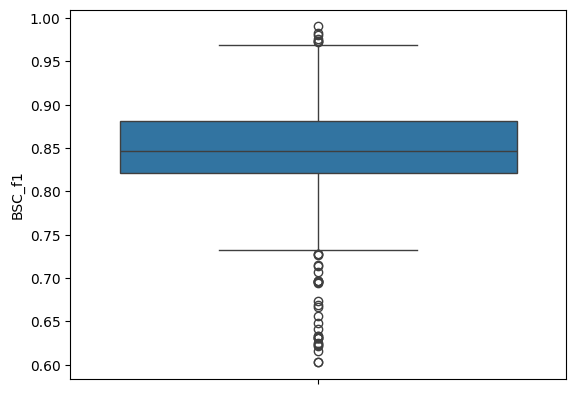

In [71]:
sns.boxplot(y=df_pred2["BSC_f1"])


<Axes: ylabel='similarity'>

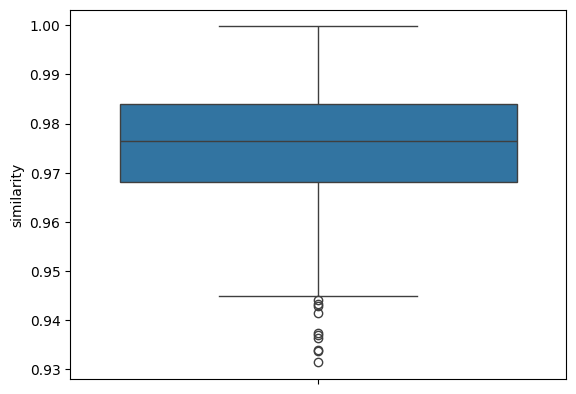

In [72]:
sns.boxplot(y=df_pred2["similarity"])

Text(0.5, 1.0, 'BertScore F1')

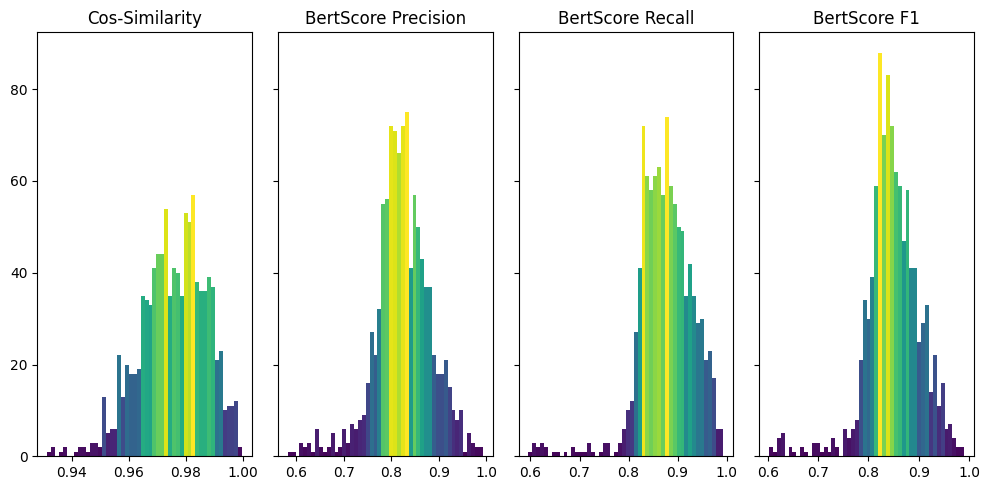

In [95]:
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

n_bins = 50

x1 = df_pred2["similarity"]
x2 = df_pred2["BSC_pre"]
x3 = df_pred2["BSC_rec"]
x4 = df_pred2["BSC_f1"]


fig, axs = plt.subplots(1, 4, sharey=True, tight_layout=True, figsize=(10,5))

# We can set the number of bins with the *bins* keyword argument.
#axs[0].hist(x1, bins=n_bins)
#axs[1].hist(x2, bins=n_bins)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0].hist(x1, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

# N is the count in each bin, bins is the lower-limit of the bin
N2, bins2, patches2 = axs[1].hist(x2, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs2 = N2 / N2.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm2 = colors.Normalize(fracs2.min(), fracs2.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs2, patches2):
    color = plt.cm.viridis(norm2(thisfrac))
    thispatch.set_facecolor(color)

# N is the count in each bin, bins is the lower-limit of the bin
N3, bins3, patches3 = axs[2].hist(x3, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs3 = N3 / N3.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm3 = colors.Normalize(fracs3.min(), fracs3.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs3, patches3):
    color = plt.cm.viridis(norm3(thisfrac))
    thispatch.set_facecolor(color)

# N is the count in each bin, bins is the lower-limit of the bin
N4, bins4, patches4 = axs[3].hist(x4, bins=n_bins)


# We'll color code by height, but you could use any scalar
fracs4 = N4 / N4.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm4 = colors.Normalize(fracs4.min(), fracs4.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs4, patches4):
    color = plt.cm.viridis(norm4(thisfrac))
    thispatch.set_facecolor(color)

axs[0].set_title('Cos-Similarity')
axs[1].set_title('BertScore Precision')
axs[2].set_title('BertScore Recall')
axs[3].set_title('BertScore F1')
